In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import os
cwd = os.getcwd()

from geopy.geocoders import Nominatim
import requests
import zipfile
from geopy.extra.rate_limiter import RateLimiter
import geopandas as gpd
import plotly.express as px
from shapely.geometry import Point

# I would like to prove that there is an observable correlation between industrial production/presence in a given region and cancer/chronic illness rates. There was a Tulane study published which implicated industrial production in the "Industrial Coridor" with elevated cancer risk. 

# I would like to first investigate and uphold these claims, and then gain insight into the emprical relation between the two phenomena, to eventually develop a model capable of predicting health consequences of industrial sites.

In [2]:
try:
    import google.colab
    from google.colab import drive
    
    drive.mount('/content/drive')
    drive_path = '/content/drive/My Drive/Data Science Final Project'

    os.chdir(drive_path)
    cwd = os.getcwd()
    colab = True

    print("Current Working Directory:", cwd)


except ImportError:
    cwd = os.getcwd()
    colab = False
    
    print("Current *Local* Working Directory:", cwd)

Current *Local* Working Directory: /home/arturo/Desktop/arturoAltamirano


In [3]:
#df = pd.read_csv(os.path.join(cwd, 'data', 'mental_health_depression_disorder Data.csv'), low_memory = False)

#first 6469 have all diseases, rest are junk 
#usa_df = df[6078:6103].copy()

#usa_df.sort_values(by='Year', ascending=True, inplace=True)

#print(tabulate(usa_df, headers='keys', tablefmt='github', showindex=False))

In [4]:
#plt.figure(figsize=(10, 5))
#plt.plot(usa_df['Year'], usa_df['Drug use disorders (%)'], marker='o')
#plt.title('Value Over Time')
#plt.xlabel('Date')
#plt.ylabel('Value')
#plt.grid(True)
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

# To frame this topic, I would like to load some preliminary data to analyze cancer rates in the US for the last ~30 years.

In [5]:
#https://www.kaggle.com/datasets/antimoni/cancer-deaths-by-country-and-type-1990-2016
df = pd.read_csv(os.path.join(cwd, 'data', 'cancer_deaths.csv'))

#isolate to only the US and order chronologically, may analyze other countries later on
usa_df = df[df['Code'] == 'USA'].copy()
usa_df.columns = usa_df.columns.str.strip()
usa_df.sort_values(by='Year', ascending=True, inplace=True)

print(tabulate(usa_df, headers='keys', tablefmt='github', showindex=False))

| Country       | Code   |   Year |   Liver cancer |   Kidney cancer |   Larynx cancer |   Breast cancer |   Thyroid cancer |   Stomach cancer |   Bladder cancer |   Uterine cancer |   Ovarian cancer |   Cervical cancer |   Prostate cancer |   Pancreatic cancer |   Esophageal cancer |   Testicular cancer |   Nasopharynx cancer |   Other pharynx cancer |   Colon and rectum cancer |   Non-melanoma skin cancer |   Lip and oral cavity cancer |   Brain and nervous system cancer |   Tracheal, bronchus, and lung cancer |   Gallbladder and biliary tract cancer |   Malignant skin melanoma |   Leukemia |   Hodgkin lymphoma |   Multiple myeloma |   Other cancers |
|---------------|--------|--------|----------------|-----------------|-----------------|-----------------|------------------|------------------|------------------|------------------|------------------|-------------------|-------------------|---------------------|---------------------|---------------------|----------------------|--------

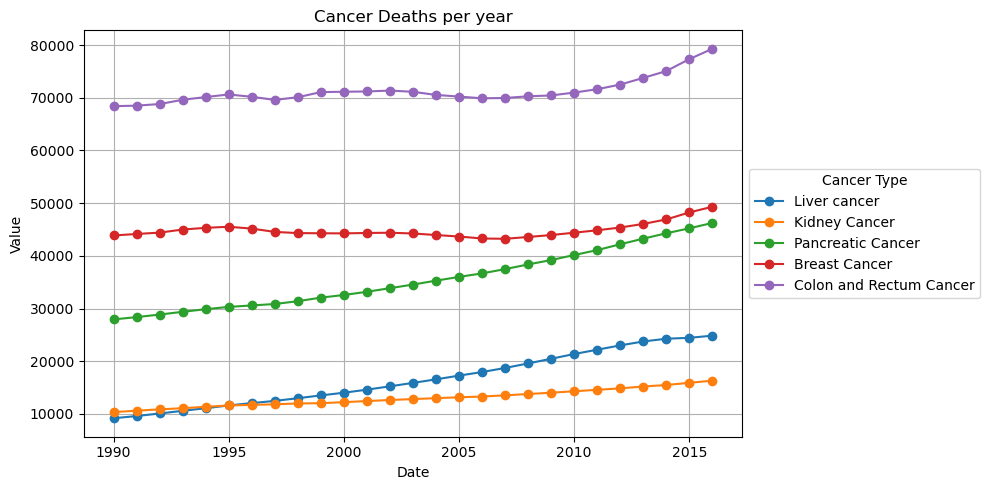

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(usa_df['Year'], usa_df['Liver cancer'], marker='o', label='Liver cancer')
plt.plot(usa_df['Year'], usa_df['Kidney cancer'], marker='o', label = 'Kidney Cancer')
plt.plot(usa_df['Year'], usa_df['Pancreatic cancer'], marker='o', label = 'Pancreatic Cancer')
plt.plot(usa_df['Year'], usa_df['Breast cancer'], marker='o', label = 'Breast Cancer')
plt.plot(usa_df['Year'], usa_df['Colon and rectum cancer'], marker='o', label = 'Colon and Rectum Cancer')

plt.title('Cancer Deaths per year')
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Cancer Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# Cancer rates are rising nationwide, and there are many more whose lives are affected by the disease who are not reflected here.

# Can we identify a potential cause of this increase? As stated previously, industrial effects are often blamed. How valid are these acquisations? 

In [7]:
#https://www.kaggle.com/datasets/snmahsa/water-quality-and-sewage-system-dataset
df = pd.read_csv(os.path.join(cwd, 'data', 'water_pollution.csv'))

#df = df[0:5000].copy()

#going to use these to track positional data 
geolocator = Nominatim(user_agent="geoapi")
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

"""
def get_us_city(lat, lon):
    try:
        location = geocode((lat, lon), language='en')
        if location is not None and 'address' in location.raw:
            address = location.raw['address']
            if address.get('country') == 'United States':
                #get state 
                return address.get('state') or 'Unknown state'
        return None
    
    except:
        return None


# Apply function to get countries (None where failed)
df['State'] = df.apply(
    lambda row: get_us_city(row['Geographical Location (Latitude)'], row['Geographical Location (Longitude)']),
    axis=1
)

# Drop rows with no country found
df_clean = df.dropna(subset=['State'])

df_clean.to_pickle('us_locations.pkl')

print(tabulate(df_clean, headers='keys', tablefmt='github', showindex=False))
"""


"\ndef get_us_city(lat, lon):\n    try:\n        location = geocode((lat, lon), language='en')\n        if location is not None and 'address' in location.raw:\n            address = location.raw['address']\n            if address.get('country') == 'United States':\n                #get state \n                return address.get('state') or 'Unknown state'\n        return None\n    \n    except:\n        return None\n\n\n# Apply function to get countries (None where failed)\ndf['State'] = df.apply(\n    lambda row: get_us_city(row['Geographical Location (Latitude)'], row['Geographical Location (Longitude)']),\n    axis=1\n)\n\n# Drop rows with no country found\ndf_clean = df.dropna(subset=['State'])\n\ndf_clean.to_pickle('us_locations.pkl')\n\nprint(tabulate(df_clean, headers='keys', tablefmt='github', showindex=False))\n"

# Below are samplings of soil with respective coordinates, I will analyze this data nationally and filter down to the state level.

In [8]:
df_us = pd.read_pickle('us_locations.pkl')

print(tabulate(df_us, headers='keys', tablefmt='github', showindex=False))

|   Geographical Location (Latitude) |   Geographical Location (Longitude) | Sampling Date   |   Nitrogen (mg/L) |   Phosphorus (mg/L) | State of Sewage System   | State          |
|------------------------------------|-------------------------------------|-----------------|-------------------|---------------------|--------------------------|----------------|
|                            68.5986 |                           -153.752  | 2014-05-08      |        8.78639    |            3.72885  | Moderate                 | Alaska         |
|                            59.5887 |                           -157.373  | 2019-04-19      |        3.74533    |            0.654298 | Good                     | Alaska         |
|                            56.4984 |                           -159.304  | 2023-10-18      |        2.07447    |            1.54363  | Moderate                 | Alaska         |
|                            48.6231 |                           -116.798  | 2014-04-15      | 

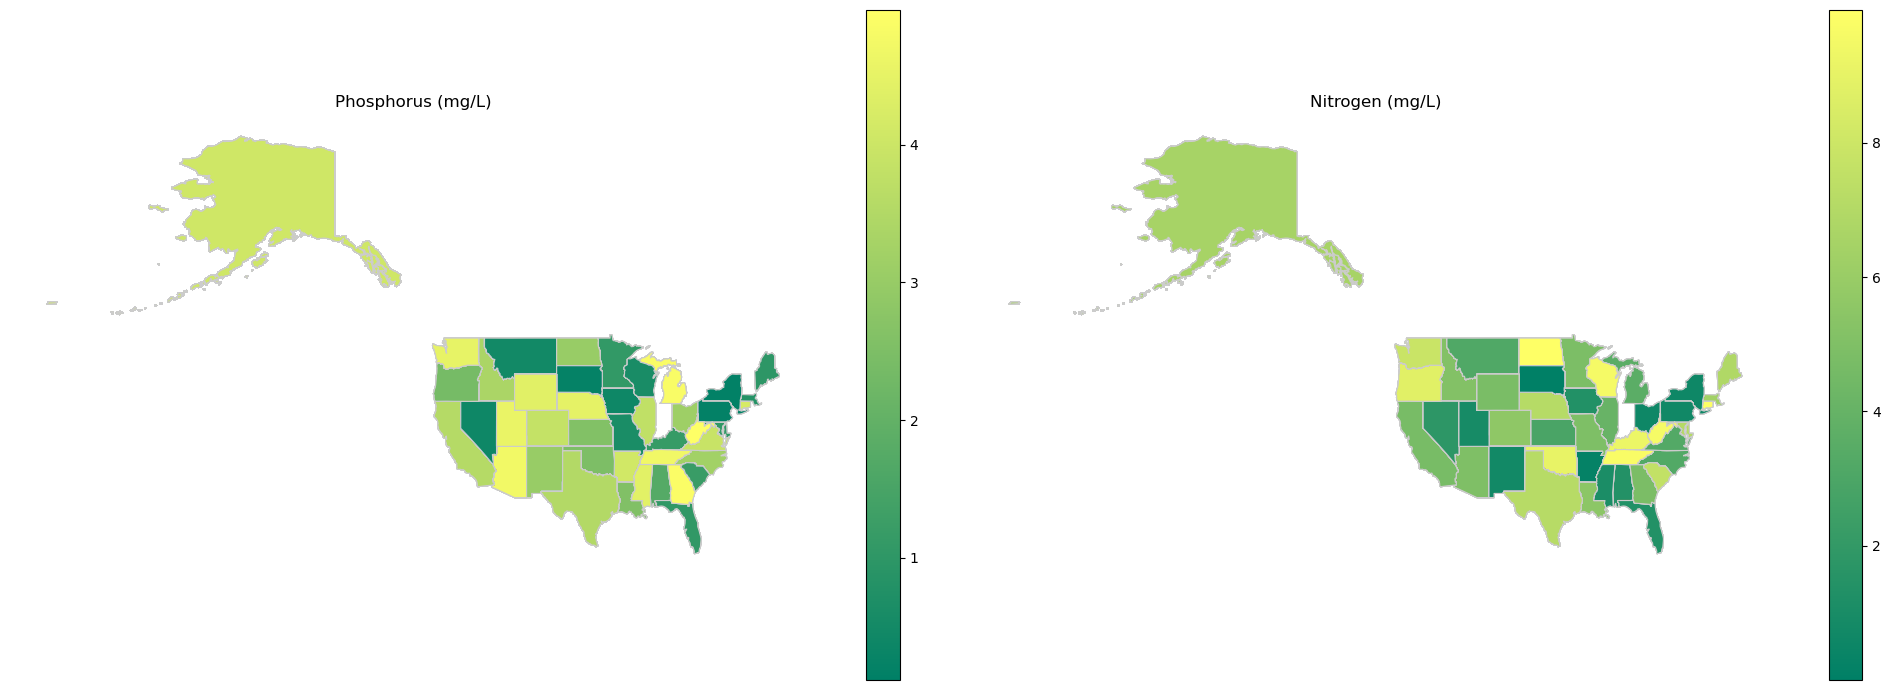

In [9]:
us_states = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')
merged_measures = us_states.merge(df_us, left_on='name', right_on='State')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

merged_measures.plot(
    column='Phosphorus (mg/L)', cmap='summer', linewidth=0.8, 
    ax=ax1, edgecolor='0.8', legend=True
)

ax1.set_title('Phosphorus (mg/L)')
ax1.axis('off')

merged_measures.plot(
    column='Nitrogen (mg/L)', cmap='summer', linewidth=0.8, 
    ax=ax2, edgecolor='0.8', legend=True
)

ax2.set_title('Nitrogen (mg/L)')
ax2.axis('off')

plt.tight_layout()
plt.show()

## Cancer Rates - national scale

In [10]:
#df = pd.read_csv('/home/arturo/Desktop/data_science/arturoAltamirano/data/cancer_reg.csv')

df = pd.read_csv(os.path.join(cwd, 'data', 'cancer_reg.csv'))

#drop the city designation and just keep the state
df['State'] = df['geography'].str.split(',').str[-1].str.strip()

#group by state and average - will use this later
state_avg = df.groupby('State').mean(numeric_only=True).reset_index()

# There seems to be a correlation between nitrogen and incidence rates of cancer, this needs further examination.

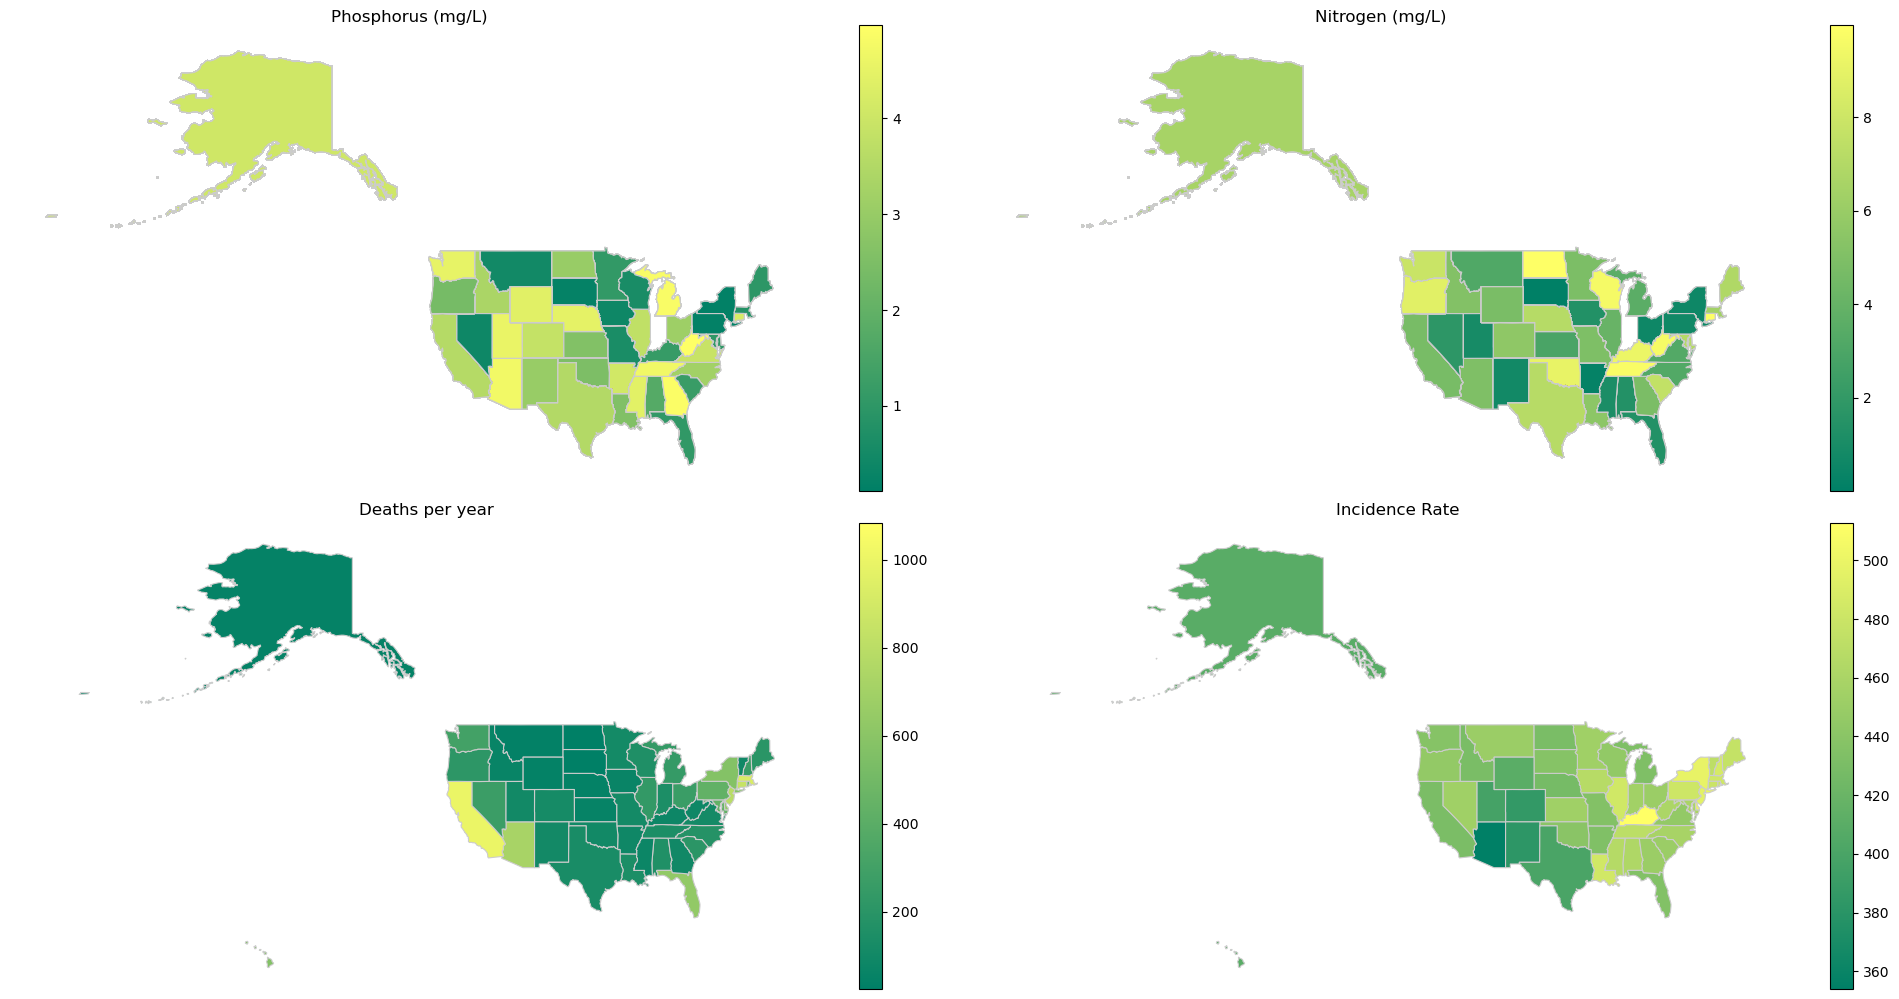

In [11]:
#load a graphic of the US using geoJSON
us_states = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

#merge in the state averages to the map
merged = us_states.merge(state_avg, left_on='name', right_on='State')

#set up 2x2 grid for future scalability (only using 2 now)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

merged_measures.plot(
    column='Phosphorus (mg/L)', cmap='summer', linewidth=0.8, 
    ax=axes[0], edgecolor='0.8', legend=True
)
axes[0].set_title('Phosphorus (mg/L)')
axes[0].axis('off')

merged_measures.plot(
    column='Nitrogen (mg/L)', cmap='summer', linewidth=0.8,
    ax=axes[1], edgecolor='0.8', legend=True
)
axes[1].set_title('Nitrogen (mg/L)')
axes[1].axis('off')

merged.plot(column='avgdeathsperyear', cmap='summer', linewidth=0.8,
            ax=axes[2], edgecolor='0.8', legend=True)
axes[2].set_title('Deaths per year')
axes[2].axis('off')

merged.plot(column='incidencerate', cmap='summer', linewidth=0.8,
            ax=axes[3], edgecolor='0.8', legend=True)
axes[3].set_title('Incidence Rate')
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [12]:
#bring in state populations so i can do per capita metrics - want to try scaling to reflect population
df_population = pd.read_csv(os.path.join(cwd, 'data', 'us_pop_by_state.csv'))

print(df_population)

fig = px.choropleth(
    df_population,
    locations='state_code',
    locationmode="USA-states",
    color='percent_of_total',
    color_continuous_scale="Viridis",
    scope="usa",
    labels={'2020_census': 'Population (2020)'},
    title='2020 Population by State'
)

#fig.show()

    rank           state state_code  2020_census  percent_of_total
0    1.0      California         CA     39538223            0.1191
1    2.0           Texas         TX     29145505            0.0874
2    3.0         Florida         FL     21538187            0.0647
3    4.0        New York         NY     20201249            0.0586
4    5.0    Pennsylvania         PA     13002700            0.0386
5    6.0        Illinois         IL     12801989            0.0382
6    7.0            Ohio         OH     11799448            0.0352
7    8.0         Georgia         GA     10711908            0.0320
8    9.0  North Carolina         NC     10439388            0.0316
9   10.0        Michigan         MI     10077331            0.0301
10  11.0      New Jersey         NJ      9288994            0.0268
11  12.0        Virginia         VA      8631393            0.0257
12  13.0      Washington         WA      7705281            0.0229
13  14.0         Arizona         AZ      7151502            0.

# Compile some more metrics about the states and their cancer fatalities. I also bring in age metrics to do per capita and age adjusted calculations.

In [13]:
#median age by state
df = pd.read_csv(os.path.join(cwd, 'data', 'us-cities-demographics.csv'), delimiter=';')

#group by states and average over median age column
state_avg_age = df.groupby('State')['Median Age'].mean().reset_index()

print(tabulate(state_avg_age, headers='keys', tablefmt='github', showindex=False))

| State                |   Median Age |
|----------------------|--------------|
| Alabama              |      36.1618 |
| Alaska               |      32.2    |
| Arizona              |      35.0375 |
| Arkansas             |      32.7379 |
| California           |      36.174  |
| Colorado             |      35.8188 |
| Connecticut          |      35.0026 |
| Delaware             |      36.4    |
| District of Columbia |      33.8    |
| Florida              |      39.5288 |
| Georgia              |      33.8091 |
| Hawaii               |      41.4    |
| Idaho                |      34.7667 |
| Illinois             |      35.7088 |
| Indiana              |      33.8275 |
| Iowa                 |      32.5441 |
| Kansas               |      34.8286 |
| Kentucky             |      35.95   |
| Louisiana            |      34.625  |
| Maine                |      40.3    |
| Maryland             |      36.37   |
| Massachusetts        |      35.5464 |
| Michigan             |      37.0114 |


In [14]:
state_avg.rename(columns={'State': 'state'}, inplace=True)
state_avg_age.rename(columns={'State': 'state'}, inplace=True)

# Merge census data first
merged_df = pd.merge(state_avg, df_population[['state', '2020_census']], on='state', how='left')

# Merge median age into the same merged_df
merged_df = pd.merge(merged_df, state_avg_age[['state', 'Median Age']], on='state', how='left')

print(tabulate(merged_df, headers='keys', tablefmt='github', showindex=False))

| state                |   avganncount |   avgdeathsperyear |   target_deathrate |   incidencerate |   medincome |   popest2015 |   povertypercent |   studypercap |   medianage |   medianagemale |   medianagefemale |   percentmarried |   pctnohs18_24 |   pcths18_24 |   pctsomecol18_24 |   pctbachdeg18_24 |   pcths25_over |   pctbachdeg25_over |   pctemployed16_over |   pctunemployed16_over |   pctprivatecoverage |   pctprivatecoveragealone |   pctempprivcoverage |   pctpubliccoverage |   pctpubliccoveragealone |   pctwhite |   pctblack |   pctasian |   pctotherrace |   pctmarriedhouseholds |   birthrate |      2020_census |   Median Age |
|----------------------|---------------|--------------------|--------------------|-----------------|-------------|--------------|------------------|---------------|-------------|-----------------|-------------------|------------------|----------------|--------------|-------------------|-------------------|----------------|---------------------|-------

In [15]:
#experimenting with different measurements
#merged_df['adjusted death rate'] = ((merged_df['avgdeathsperyear'] / merged_df['2020_census']) * 1_000_000) / (merged_df['Median Age'] ** 2)
#merged_df['adjusted diagnosis rate'] = ((merged_df['avganncount'] / merged_df['2020_census']) * 1_000_000) / (merged_df['Median Age'] ** 2)

#print(tabulate(merged_df, headers='keys', tablefmt='github', showindex=False))

In [16]:
"""
merged = us_states.merge(merged_df, left_on='name', right_on='state')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 8))

merged.plot(column='avgdeathsperyear', cmap='summer', linewidth=0.8,
            ax=ax1, edgecolor='0.8', legend=True)
ax1.set_title('Deaths per year')

ax1.axis('off')

merged.plot(column='incidencerate', cmap='summer', linewidth=0.8,
            ax=ax2, edgecolor='0.8', legend=True)
ax2.set_title('Incidence Rate')

ax2.axis('off')

merged.plot(column='adjusted death rate', cmap='summer', linewidth=0.8,
            ax=ax3,legend=True)
ax3.set_title('PC Death Rate')

ax3.axis('off')

merged.plot(column='adjusted diagnosis rate', cmap='summer', linewidth=0.8,
            ax=ax4,legend=True)
ax4.set_title('PC Diagnosis Rate')

ax4.axis('off')

plt.tight_layout()
plt.show()
"""

"\nmerged = us_states.merge(merged_df, left_on='name', right_on='state')\n\nfig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 8))\n\nmerged.plot(column='avgdeathsperyear', cmap='summer', linewidth=0.8,\n            ax=ax1, edgecolor='0.8', legend=True)\nax1.set_title('Deaths per year')\n\nax1.axis('off')\n\nmerged.plot(column='incidencerate', cmap='summer', linewidth=0.8,\n            ax=ax2, edgecolor='0.8', legend=True)\nax2.set_title('Incidence Rate')\n\nax2.axis('off')\n\nmerged.plot(column='adjusted death rate', cmap='summer', linewidth=0.8,\n            ax=ax3,legend=True)\nax3.set_title('PC Death Rate')\n\nax3.axis('off')\n\nmerged.plot(column='adjusted diagnosis rate', cmap='summer', linewidth=0.8,\n            ax=ax4,legend=True)\nax4.set_title('PC Diagnosis Rate')\n\nax4.axis('off')\n\nplt.tight_layout()\nplt.show()\n"

# Narrowing the scope to Louisiana to further investigate the relationship between nitrogen/phosphorus and cancer incidence.

In [17]:
#median age by state
df = pd.read_csv(os.path.join(cwd, 'data', 'county_zip_reg.csv'), encoding='latin1')

#filter for only those whose county field (County, State) contains Louisiana
filtered_df = df[df['County'].str.contains('Louisiana', case=False, na=False)]

#
countyTotals = filtered_df.groupby('County').agg({
    'incidenceRate': 'mean',
    'deathRate': 'mean',
    'avgDeathsPerYear': 'mean',
}).reset_index()

#countyTotals = filtered_df.groupby('County')['incidenceRate'].mean().reset_index()

#drop the parish designation (Acadiana Parish -> Acadiana) to match other formats
countyTotals['County'] = countyTotals['County'].str.split('Parish').str[0].str.strip()

#prevent capitilization issues by forcing to capital 
countyTotals['County'] = countyTotals['County'].str.title()

#print(countyTotals)

#US counties shapefile from Census TIGER/Line (found this online)

#counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip")

if colab == True:
    counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip")

else: 
    with zipfile.ZipFile("/home/arturo/Desktop/arturoAltamirano/data/cb_2018_us_county_500k.zip", "r") as zip_ref:
        zip_ref.extractall("county_shapefiles")

    counties = gpd.read_file(os.path.join(cwd, 'county_shapefiles','cb_2018_us_county_500k.shp'), encoding='latin1')

    #Louisiana ID number is 22
la_counties = counties[counties['STATEFP'] == '22']

    #merge the nitrogen samples dataset and cancer rates dataset on the county column
merged = la_counties.merge(countyTotals, left_on='NAME', right_on='County')

print("County names in la_counties:")
print(sorted(la_counties['NAME'].unique()))

print("\nCounty names in countyTotals:")
print(sorted(countyTotals['County'].unique()))

County names in la_counties:
['Acadia', 'Allen', 'Ascension', 'Assumption', 'Avoyelles', 'Beauregard', 'Bienville', 'Bossier', 'Caddo', 'Calcasieu', 'Caldwell', 'Cameron', 'Catahoula', 'Claiborne', 'Concordia', 'De Soto', 'East Baton Rouge', 'East Carroll', 'East Feliciana', 'Evangeline', 'Franklin', 'Grant', 'Iberia', 'Iberville', 'Jackson', 'Jefferson', 'Jefferson Davis', 'LaSalle', 'Lafayette', 'Lafourche', 'Lincoln', 'Livingston', 'Madison', 'Morehouse', 'Natchitoches', 'Orleans', 'Ouachita', 'Plaquemines', 'Pointe Coupee', 'Rapides', 'Red River', 'Richland', 'Sabine', 'St. Bernard', 'St. Charles', 'St. Helena', 'St. James', 'St. John the Baptist', 'St. Landry', 'St. Martin', 'St. Mary', 'St. Tammany', 'Tangipahoa', 'Tensas', 'Terrebonne', 'Union', 'Vermilion', 'Vernon', 'Washington', 'Webster', 'West Baton Rouge', 'West Carroll', 'West Feliciana', 'Winn']

County names in countyTotals:
['Acadia', 'Allen', 'Ascension', 'Assumption', 'Avoyelles', 'Beauregard', 'Bienville', 'Bossier'

# Interested to see how the most prominent industrial facilities line up with the cancer rates and nitrogen samples.

In [18]:
#points of industrial facilities - https://onmyside.com/faqs/full-list-of-oil-refineries-in-louisiana/
points_df = pd.DataFrame({
    'Latitude': [30.483988, 29.846726, 29.938748, 30.031041, 32.797383, 30.065276, 30.526713, 30.240865, 29.933837,  29.995503, 30.476733, 32.470366],
    'Longitude': [-91.169601, -89.991966, -89.970822, -90.897768, -93.415004, -90.593545, -91.746182, -93.272194, -89.944371, -90.409877, -91.210874, -93.789677],
    'Label': ['Baton Rouge Refinery', 'Alliance Refinery', 'Chalmette Refinery', 'Convent Refinery', 'Cotton Valley Refinery',
              'Garyville Refinery','Delek Refinery', 'Phillips 66 Lake Charles', 'Meraux Valero', 'Shell Norco', 'Placid Refinery Port Allen', 'Calumet Shreveport']
})

#convert lat/lon to Point geometry using shapely.point 
geometry = [Point(xy) for xy in zip(points_df['Longitude'], points_df['Latitude'])]
points_gdf = gpd.GeoDataFrame(points_df, geometry=geometry, crs='EPSG:4326') # going based off documentation here, don't know what crs is 

#apparently you need to 'reproject' these
points_gdf = points_gdf.to_crs(merged.crs)

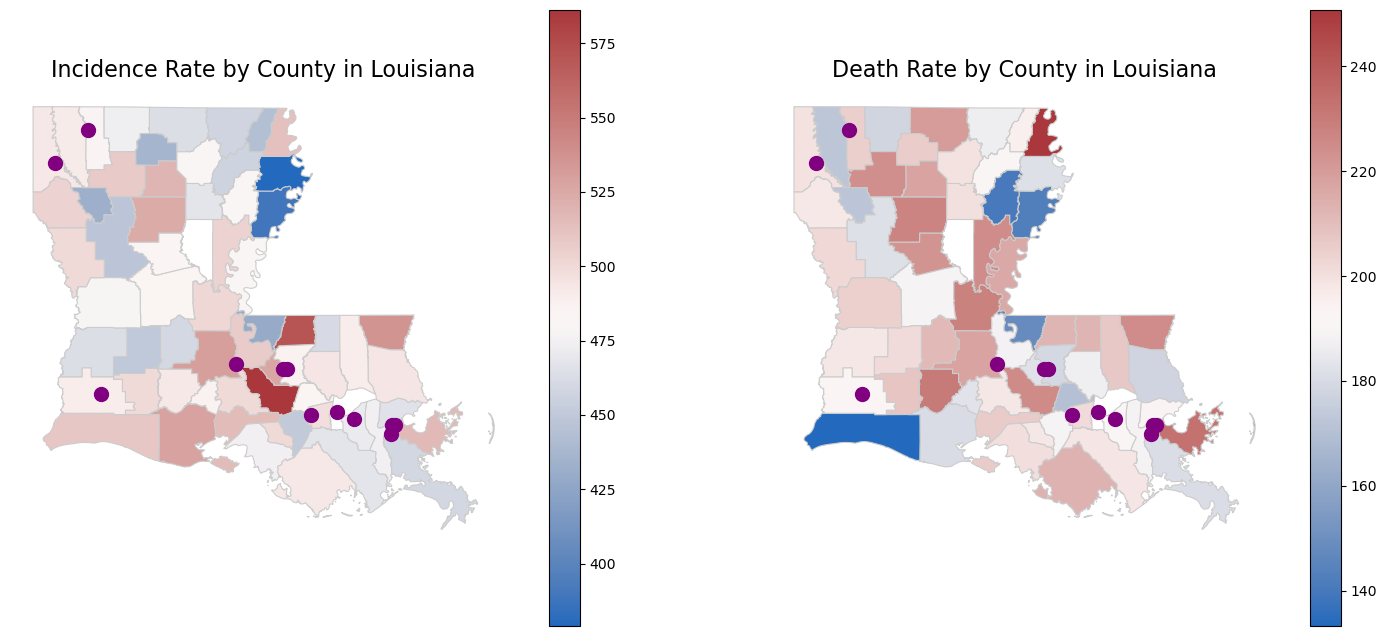

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

merged.plot(column='incidenceRate', cmap='vlag', linewidth=0.8,
            ax=ax1, edgecolor='0.8', legend=True, aspect=1)
points_gdf.plot(ax=ax1, color='purple', markersize=100)

ax1.set_title("Incidence Rate by County in Louisiana", fontsize=16)
ax1.set_axis_off()

merged.plot(column='deathRate', cmap='vlag', linewidth=0.8,
            ax=ax2, edgecolor='0.8', legend=True, aspect=1)
points_gdf.plot(ax=ax2, color='purple', markersize=100)

ax2.set_title("Death Rate by County in Louisiana", fontsize=16)
ax2.set_axis_off()

#merged.plot(column='avgDeathsPerYear', cmap='vlag', linewidth=0.8,
#            ax=ax3, edgecolor='0.8', legend=True, aspect=1)
#points_gdf.plot(ax=ax3, color='purple', markersize=100)

#ax3.set_title("Average Annual Counts", fontsize=16)
#ax3.set_axis_off()

plt.show()

## There are unfortunately not enough variety in the nitrogen samples taken here in this dataset (16 samples from only 4 parishes)

In [20]:
#isolate only Louisiana from all state data
df_LA = df_us[df_us['State'].str.contains('Louisiana', case=False, na=False)]

print(len(df_LA))

16


In [21]:
def get_county(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), language='en', exactly_one=True, timeout=10)
        if location and 'address' in location.raw:
            address = location.raw['address']
            return address.get('county') or address.get('parish') or address.get('state_district') or address.get('region')
        
        return None
    
    except Exception as e:
        print(f"Error at ({lat},{lon}): {e}")
        return None
    
df_LA['County'] = df_LA.apply(lambda row: get_county(row['Geographical Location (Latitude)'], row['Geographical Location (Longitude)']), axis=1)

#print(df_LA)

/tmp/ipykernel_6951/824877126.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
countyTotals = df_LA.groupby('County').agg({
    'Nitrogen (mg/L)': 'mean',
    'Phosphorus (mg/L)': 'mean'
}).reset_index()

countyTotals['County'] = countyTotals['County'].str.split('Parish').str[0].str.strip()

countyTotals['County'] = countyTotals['County'].str.title()

print(countyTotals)

if colab == True:
    counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip")

else: 
    with zipfile.ZipFile("/home/arturo/Desktop/arturoAltamirano/data/cb_2018_us_county_500k.zip", "r") as zip_ref:
        zip_ref.extractall("county_shapefiles")

    counties = gpd.read_file(os.path.join(cwd, 'county_shapefiles','cb_2018_us_county_500k.shp'), encoding='latin1')

la_counties = counties[counties['STATEFP'] == '22']

merged = la_counties.merge(countyTotals, left_on='NAME', right_on='County', how='left')

        County  Nitrogen (mg/L)  Phosphorus (mg/L)
0       Acadia         2.718586           0.336420
1      Cameron         5.493093           2.569414
2   Evangeline         0.765560           2.960402
3  St. Tammany         6.711428           1.769724


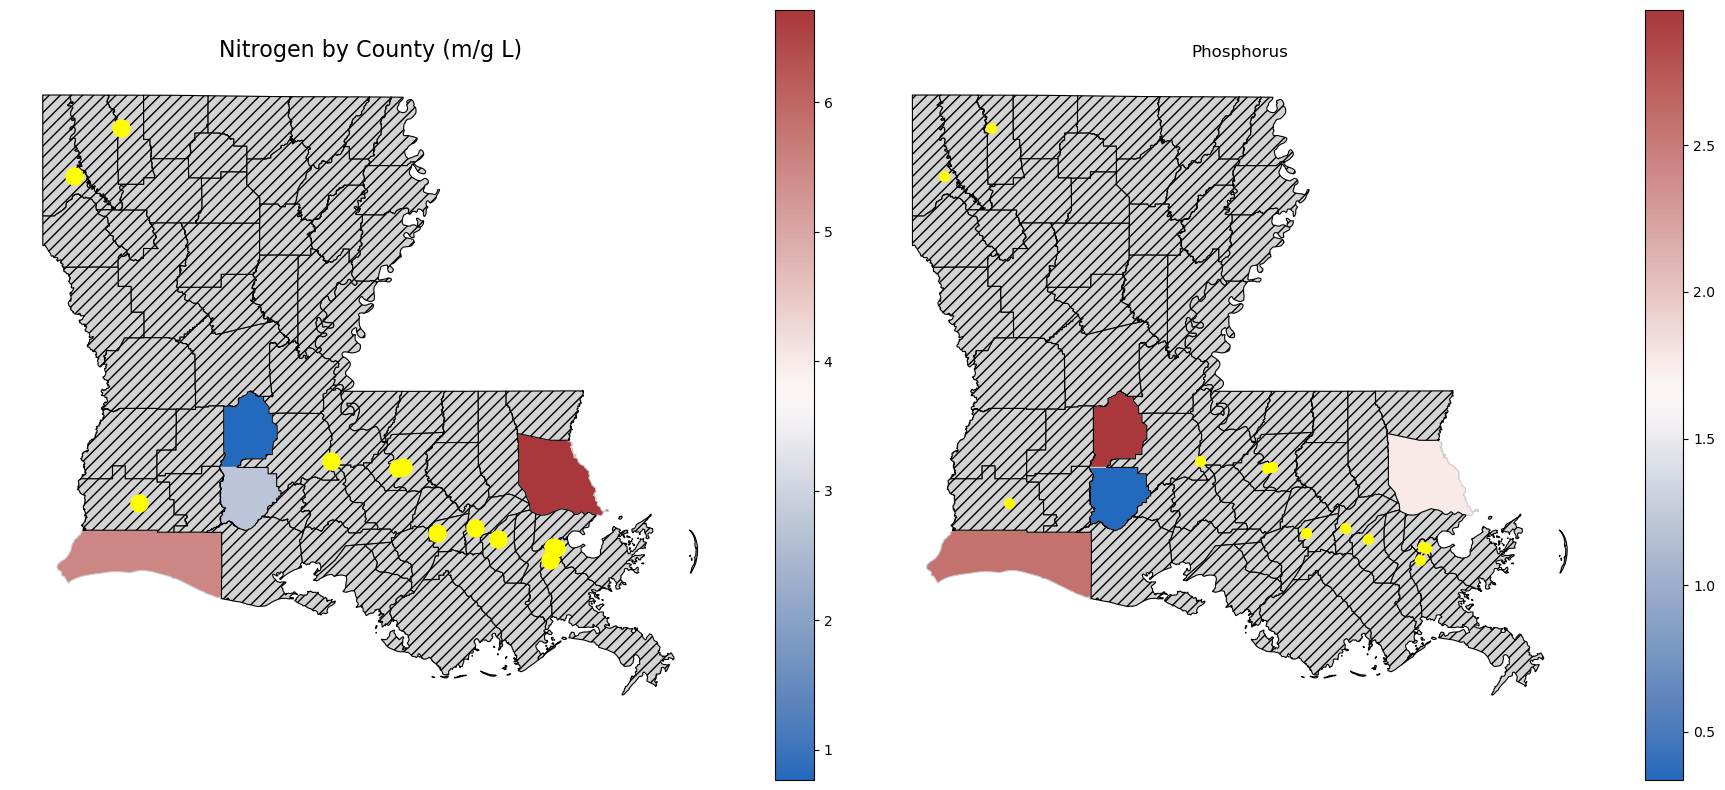

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

merged.plot(column='Nitrogen (mg/L)', cmap='vlag', linewidth=0.8, ax=ax1, 
            edgecolor='0.8', legend=True,
            missing_kwds={
                "color": "lightgrey",
                "edgecolor": "black",
                "hatch": "///",
                "label": "No data"
            })
points_gdf.plot(ax=ax1, color='yellow', markersize=150)

ax1.set_title("Nitrogen by County (m/g L)", fontsize=16)

ax1.set_axis_off()

merged.plot(column='Phosphorus (mg/L)', cmap='vlag', linewidth=0.8, ax=ax2, 
            edgecolor='0.8', legend=True,
            missing_kwds={
                "color": "lightgrey",
                "edgecolor": "black",
                "hatch": "///",
                "label": "No data"
            })
points_gdf.plot(ax=ax2, color='yellow', markersize=50)

ax2.set_title('Phosphorus')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Since there isn't enough data for Louisiana, I am going to analyze the most sampled states.

In [24]:
"""
countyTotals = df_LA.groupby('County').agg({
    'Nitrogen (mg/L)': 'mean',
    'Phosphorus (mg/L)': 'mean'
}).reset_index()

countyTotals['County'] = countyTotals['County'].str.split('Parish').str[0].str.strip()

countyTotals['County'] = countyTotals['County'].str.title()

print(countyTotals)

if colab == True:
    counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip")

else: 
    with zipfile.ZipFile("/home/arturo/Desktop/arturoAltamirano/data/cb_2018_us_county_500k.zip", "r") as zip_ref:
        zip_ref.extractall("county_shapefiles")

    counties = gpd.read_file(os.path.join(cwd, 'county_shapefiles','cb_2018_us_county_500k.shp'), encoding='latin1')

la_counties = counties[counties['STATEFP'] == '22']

merged = la_counties.merge(countyTotals, left_on='NAME', right_on='County', how='left')
"""

'\ncountyTotals = df_LA.groupby(\'County\').agg({\n    \'Nitrogen (mg/L)\': \'mean\',\n    \'Phosphorus (mg/L)\': \'mean\'\n}).reset_index()\n\ncountyTotals[\'County\'] = countyTotals[\'County\'].str.split(\'Parish\').str[0].str.strip()\n\ncountyTotals[\'County\'] = countyTotals[\'County\'].str.title()\n\nprint(countyTotals)\n\nif colab == True:\n    counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip")\n\nelse: \n    with zipfile.ZipFile("/home/arturo/Desktop/arturoAltamirano/data/cb_2018_us_county_500k.zip", "r") as zip_ref:\n        zip_ref.extractall("county_shapefiles")\n\n    counties = gpd.read_file(os.path.join(cwd, \'county_shapefiles\',\'cb_2018_us_county_500k.shp\'), encoding=\'latin1\')\n\nla_counties = counties[counties[\'STATEFP\'] == \'22\']\n\nmerged = la_counties.merge(countyTotals, left_on=\'NAME\', right_on=\'County\', how=\'left\')\n'

In [25]:
def nitrogen_samples(df, fips_code, state_name):
    df_state_nitrogen = df[df['State'].str.contains(state_name, case=False, na=False)]

    df_state_nitrogen['County'] = df_state_nitrogen.apply(lambda row: get_county(row['Geographical Location (Latitude)'], row['Geographical Location (Longitude)']), axis=1)

    ############################################

    countyTotals = df_state_nitrogen.groupby('County').agg({
    'Nitrogen (mg/L)': 'mean',
    'Phosphorus (mg/L)': 'mean'
    }).reset_index()

    countyTotals['County'] = countyTotals['County'].str.split('Parish').str[0].str.strip()
    countyTotals['County'] = countyTotals['County'].str.split('County').str[0].str.strip()

    countyTotals['County'] = countyTotals['County'].str.title()

    print(countyTotals)

    if colab == True:
        counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip")

    else: 
        with zipfile.ZipFile("/home/arturo/Desktop/arturoAltamirano/data/cb_2018_us_county_500k.zip", "r") as zip_ref:
            zip_ref.extractall("county_shapefiles")
            counties = gpd.read_file(os.path.join(cwd, 'county_shapefiles','cb_2018_us_county_500k.shp'), encoding='latin1')

    state_counties = counties[counties['STATEFP'] == fips_code]

    merged = state_counties.merge(countyTotals, left_on='NAME', right_on='County', how='left')

    return merged
    

In [26]:
def state_countyMetrics(state_name, fips_code):
    
    df_cancer_rates = pd.read_csv(os.path.join(cwd, 'data', 'county_zip_reg.csv'), encoding='latin1')

    df_nitrogen_samples = pd.read_pickle('us_locations.pkl')

    state_nitrogen = nitrogen_samples(df_nitrogen_samples, fips_code, state_name)

    #filter for only those whose county field (County, State) contains Louisiana
    filtered_df = df_cancer_rates[df_cancer_rates['County'].str.contains(state_name, case=False, na=False)]

    #
    countyTotals = filtered_df.groupby('County').agg({
        'incidenceRate': 'mean',
        'deathRate': 'mean',
        'avgDeathsPerYear': 'mean',
    }).reset_index()

    #countyTotals = filtered_df.groupby('County')['incidenceRate'].mean().reset_index()

    #add if here for if contains parish or county - for now just do both

    #drop the parish designation (Acadiana Parish -> Acadiana) to match other formats
    countyTotals['County'] = countyTotals['County'].str.split('Parish').str[0].str.strip()

    countyTotals['County'] = countyTotals['County'].str.split('County').str[0].str.strip()

    #prevent capitilization issues by forcing to capital 
    countyTotals['County'] = countyTotals['County'].str.title()

    #print(countyTotals)

    if colab == True:
        counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip")

    else: 
        with zipfile.ZipFile("/home/arturo/Desktop/arturoAltamirano/data/cb_2018_us_county_500k.zip", "r") as zip_ref:
            zip_ref.extractall("county_shapefiles")
            
        counties = gpd.read_file(os.path.join(cwd, 'county_shapefiles','cb_2018_us_county_500k.shp'), encoding='latin1')
    
    #Louisiana ID number is 22
    la_counties = counties[counties['STATEFP'] == fips_code]

    #merge the nitrogen samples dataset and cancer rates dataset on the county column
    merged = la_counties.merge(countyTotals, left_on='NAME', right_on='County')

    merged['Nitrogen (mg/L)'] = state_nitrogen['Nitrogen (mg/L)']
    merged['Phosphorus (mg/L)'] = state_nitrogen['Phosphorus (mg/L)']

    #print("County names in la_counties:")
    #print(sorted(la_counties['NAME'].unique()))

    #print("\nCounty names in countyTotals:")
    #print(sorted(countyTotals['County'].unique()))

    return merged

In [27]:
def nitrogen_plotter(merged):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    merged.plot(column='Nitrogen (mg/L)', cmap='vlag', linewidth=0.8, ax=ax1, 
            edgecolor='0.8', legend=True,
            missing_kwds={
                "color": "lightgrey",
                "edgecolor": "black",
                "hatch": "///",
                "label": "No data"
            })
    #points_gdf.plot(ax=ax1, color='purple', markersize=150)

    ax1.set_title("Nitrogen by County (m/g L)", fontsize=16)

    ax1.set_axis_off()

    merged.plot(column='Phosphorus (mg/L)', cmap='vlag', linewidth=0.8, ax=ax2, 
            edgecolor='0.8', legend=True,
            missing_kwds={
                "color": "lightgrey",
                "edgecolor": "black",
                "hatch": "///",
                "label": "No data"
            })
    
    #points_gdf.plot(ax=ax2, color='black', markersize=50)

    ax2.set_title('Phosphorus')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [28]:
def incidence_plotter(merged, name, *args):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    merged.plot(column='incidenceRate', cmap='vlag', linewidth=0.8,
            ax=ax1, edgecolor='0.8', legend=True, aspect=1)

    ax1.set_title(f"Incidence Rate by County in {name}", fontsize=16)
    ax1.set_axis_off()

    merged.plot(column='deathRate', cmap='vlag', linewidth=0.8,
            ax=ax2, edgecolor='0.8', legend=True, aspect=1)

    ax2.set_title("Death Rate by County in Louisiana", fontsize=16)
    ax2.set_axis_off()

    points_gdf.plot(ax=ax1, color='purple', markersize=100)
    points_gdf.plot(ax=ax2, color='purple', markersize=100)

    return plt


In [29]:
merged_texas = state_countyMetrics('Texas','48')

/tmp/ipykernel_6951/3636671501.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



        County  Nitrogen (mg/L)  Phosphorus (mg/L)
0       Collin         9.571912           1.866132
1      Edwards         3.783907           2.939513
2    Fort Bend         5.504363           0.573085
3      Hockley         0.025817           0.508103
4       Potter         6.457748           3.664391
5  San Jacinto         7.023064           1.379296
6        Titus         1.728867           4.846959
7    Val Verde         9.428937           2.172659


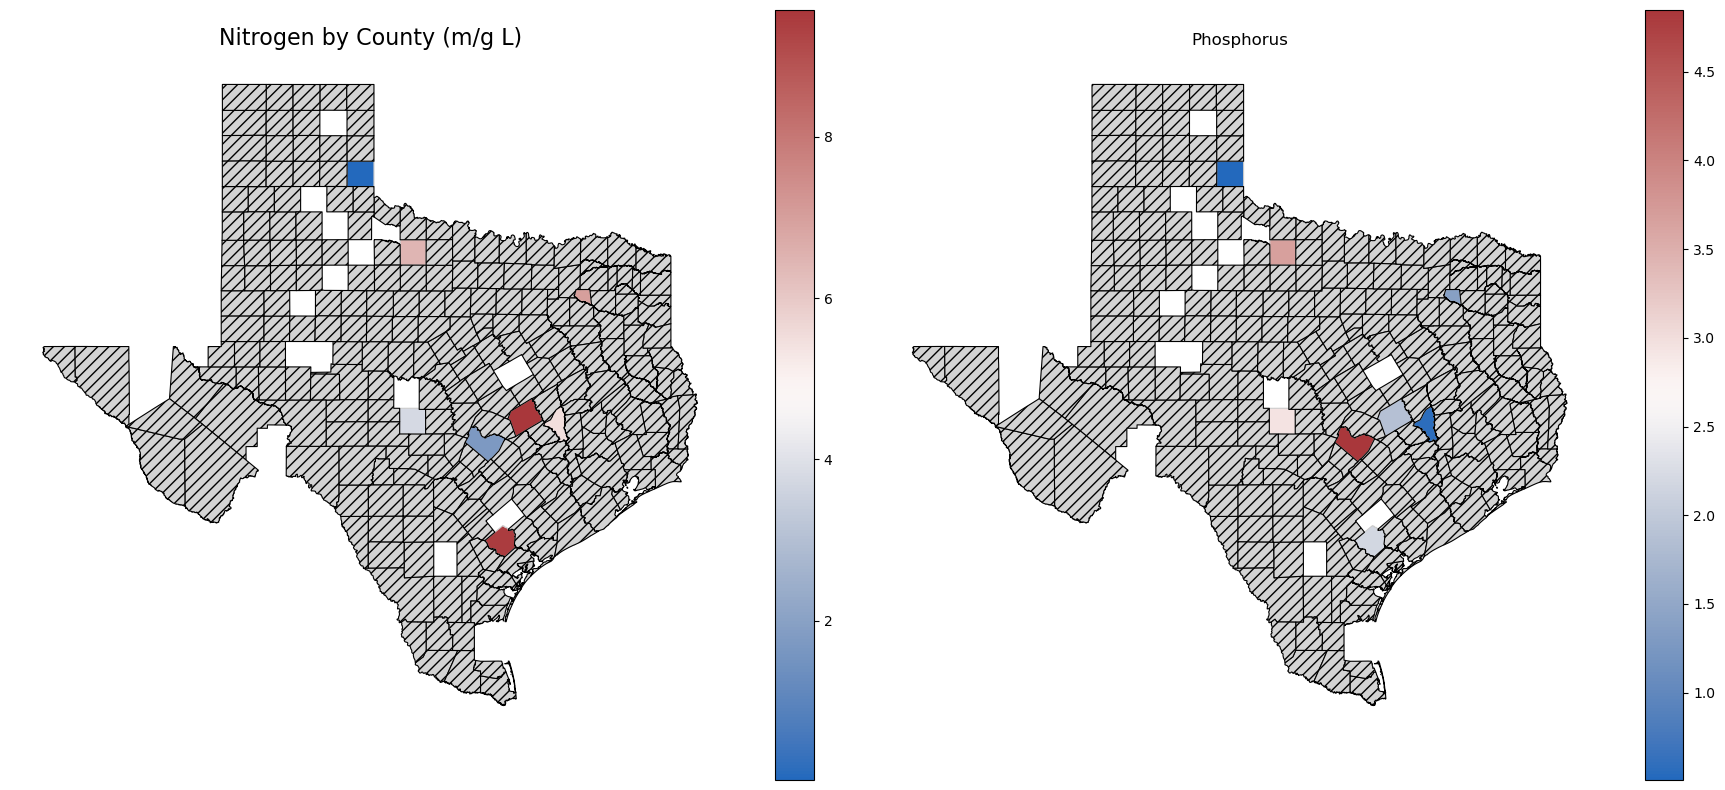

In [30]:
nitrogen_plotter(merged_texas)

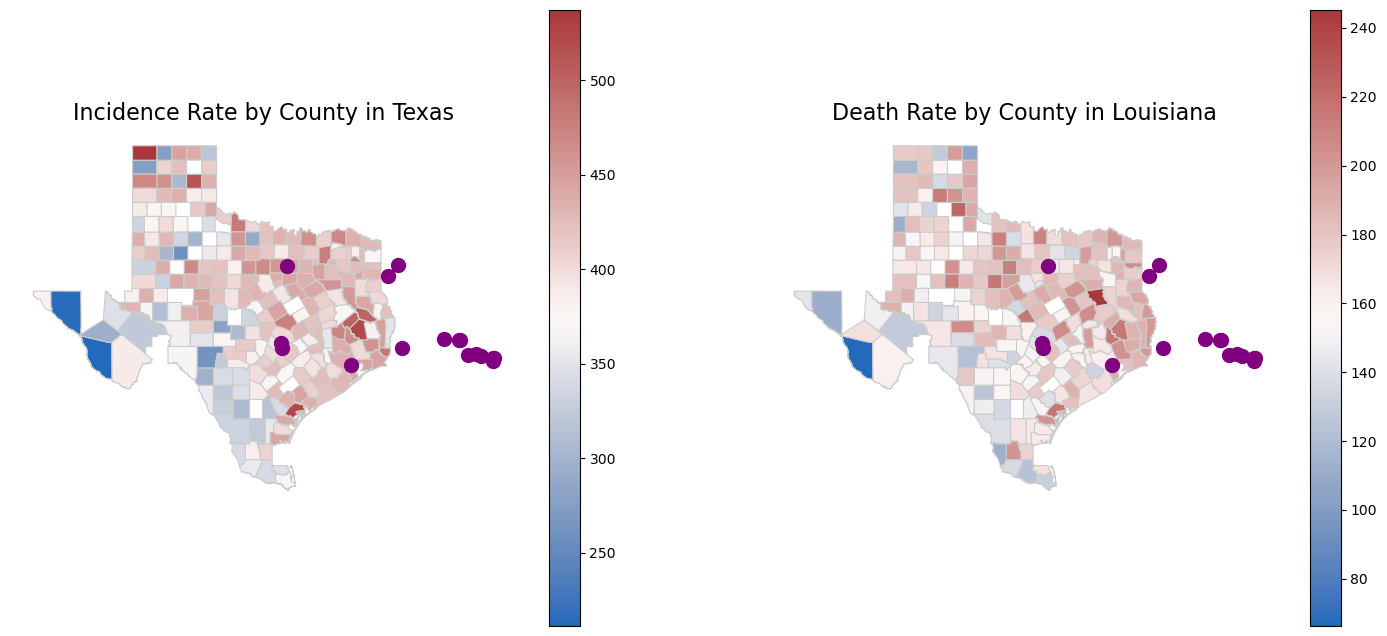

In [31]:
#points of industrial facilities - https://www.industryselect.com/blog/top-10-manufacturing-companies-in-texas
points_df = pd.DataFrame({
    'Latitude': [30.483988, 29.846726, 29.938748, 30.031041, 32.797383, 30.065276, 30.526713, 30.240865, 29.933837,  29.995503, 30.476733, 32.470366,
                 30.228790, 32.770222, 30.400474, 29.710871
                 ],

    'Longitude': [-91.169601, -89.991966, -89.970822, -90.897768, -93.415004, -90.593545, -91.746182, -93.272194, -89.944371, -90.409877, -91.210874, -93.789677,
                  -97.619720, -97.447731, -97.661238, -95.117630
                  
                  ],

    'Label': ['Baton Rouge Refinery', 'Alliance Refinery', 'Chalmette Refinery', 'Convent Refinery', 'Cotton Valley Refinery',
              'Garyville Refinery','Delek Refinery', 'Phillips 66 Lake Charles', 'Meraux Valero', 'Shell Norco', 'Placid Refinery Port Allen', 'Calumet Shreveport',
              'Tesla Austin Plant', 'Lockheed Martin Plant', 'Dell Manufacturing Facility', 'Pemex-Shell Petrochemical Plant'
              
              ]
})

#convert lat/lon to Point geometry using shapely.point 
geometry = [Point(xy) for xy in zip(points_df['Longitude'], points_df['Latitude'])]
points_gdf = gpd.GeoDataFrame(points_df, geometry=geometry, crs='EPSG:4326') # going based off documentation here, don't know what crs is 

#apparently you need to 'reproject' these
points_gdf = points_gdf.to_crs(merged.crs)

plot = incidence_plotter(merged_texas, 'Texas', points_gdf)

plot.show()

/tmp/ipykernel_6951/3636671501.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



     County  Nitrogen (mg/L)  Phosphorus (mg/L)
0   Alameda         9.086032           4.725050
1    Fresno         9.638116           2.475042
2  Humboldt         8.300976           1.373852
3  Imperial         4.602941           1.284828
4    Plumas         8.415643           3.086816
5    Shasta         1.637028           4.276512
6    Tehama         4.678557           3.563002


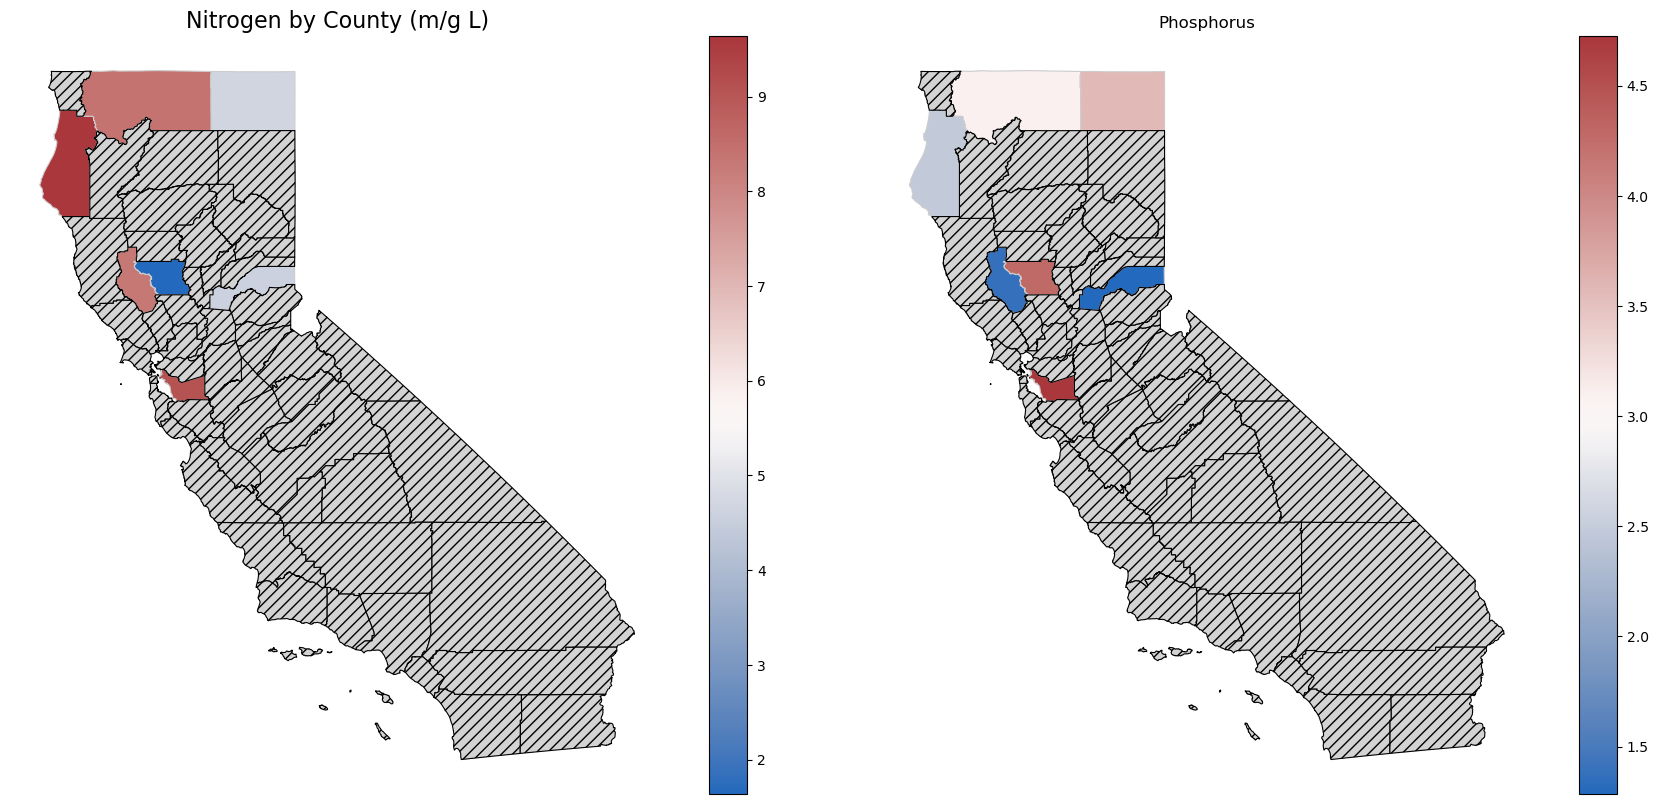

In [32]:
nitrogen_plotter(state_countyMetrics('California','06'))

/tmp/ipykernel_6951/3636671501.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



     County  Nitrogen (mg/L)  Phosphorus (mg/L)
0   Alameda         9.086032           4.725050
1    Fresno         9.638116           2.475042
2  Humboldt         8.300976           1.373852
3  Imperial         4.602941           1.284828
4    Plumas         8.415643           3.086816
5    Shasta         1.637028           4.276512
6    Tehama         4.678557           3.563002


<module 'matplotlib.pyplot' from '/home/arturo/anaconda3/envs/sampletorch/lib/python3.10/site-packages/matplotlib/pyplot.py'>

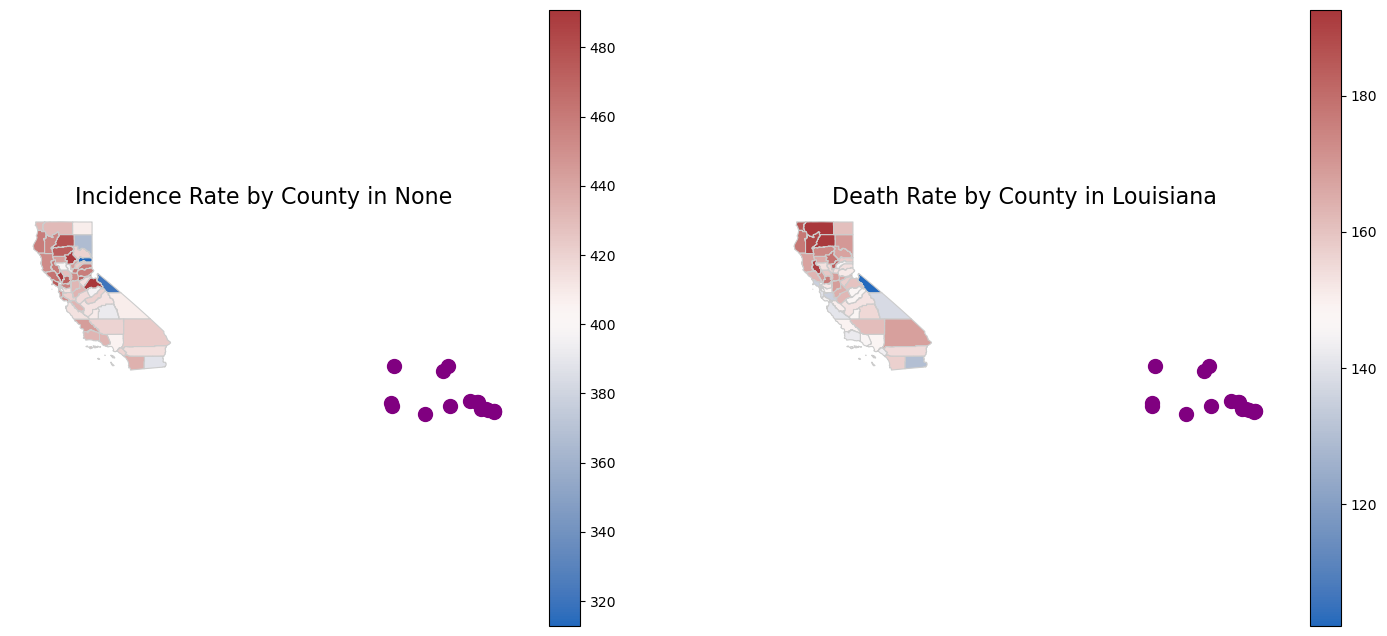

In [33]:
incidence_plotter(state_countyMetrics('California','06'), None, 'California')